# Centrality Measures

The aims of this notebook are
1. to define, describe and implement the main network centrality measures, and
2. to compare them on simulated and real-world networks.

## What is a *centrality measure?*

A centrality measure is a way to quanitfy how important the vertices are in a given network. They are all real-valued functions on the set of vertices 

$$C:V(G)\to\mathbb{R}.$$ 

Importance depends on what question you're trying to answer; if you are looking for the most popular people in a social network then you might want *degree centrality* where you say a vertex is more important if it has more neighbours. If you are studying the London Underground network, you might prefer *betweenness centrality* which will rank the nodes based on the proportion of shortest paths passing through each vertex (so if an important station by this measure is closed, you would expect journey times to increase more than if a less important station was closed).

### Notation
Let $G=(V,E)$ be a graph with $n=|V|$ vertices and $|E|$ edges. Let $A=(a_{ij})_{1\leq i,j\leq n}$ denote the adjacency matrix of a network, so that $deg(v_i)=\sum^n_{j=1} a_{ij}$ if $G$ is undirected.

## Centrality measures

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
from numpy import linalg as LA

We first generate one random graph to use as an example for all of the measures we trial here. We use a random geometric (undirected) graph with 100 vertices and radius parameter 0.2 (two vertices are connected if they are within 0.2 distance of each other).

In [5]:
G = nx.random_geometric_graph(100,0.2)
pos=nx.get_node_attributes(G,'pos')

In [6]:
def plot_centrality(G, centrality_labels, title):
    nx.draw(G, pos, node_size = 60, node_color = [centrality_labels[i] for i in G.nodes()])
    sm = plt.cm.ScalarMappable()
    sm._A = []
    plt.colorbar(sm)
    plt.title(title)
    plt.show()

### Degree centrality

The simplest centrality measure is **degree centrality**, defined as $$C(v_i) = deg(v_i).$$

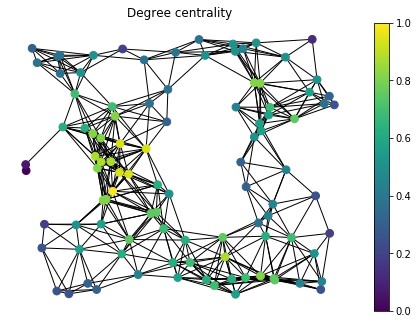

In [7]:
degree_centrality_labels = nx.degree_centrality(G)
plot_centrality(G, degree_centrality_labels, 'Degree centrality')

### Closeness centrality

This is a measure based on the distance between pairs of nodes.

$$C(v_i) = \frac{n-1}{\sum^n_{j=1,j\neq i}d(v_i,v_j)},$$

where $d(v_i,v_j)$ is the shortest path distance from vertex $i$ to vertex $j$ (if the adjacency matrix is weighted then this is a weighted distance).

This can be interpreted as the inverse of the mean distance from vertex $i$ to *any* other vertex in $G$.

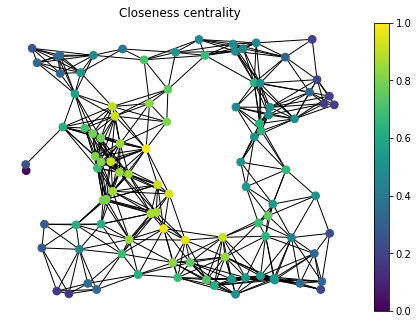

In [8]:
closeness_centrality_labels = nx.closeness_centrality(G)
plot_centrality(G, closeness_centrality_labels, 'Closeness centrality')

### Betweenness centrality

This is similar to closeness except instead it is *medial* instead of *radial*. A *medial* measure is concerned with flow passing through a given node whereas a *radial* measure is concerned with flow radiating out from a given node. With this in mind, we define betweenness centrality as the fraction of shortest paths passing through the given node.

$$C(v_i) = \frac{2}{(n-1)(n-2)}\sum^n_{j=1,j\neq i}\sum^{j-1}_{l=1,l\neq i}\frac{\sigma_{jl}^i}{\sigma_{jl}},$$

where $\sigma_{jl}$ is the number of shortest paths connecting $v_j$ to $v_l$ and $\sigma_{jl}^i$ is the number of such paths passing through $v_i$.

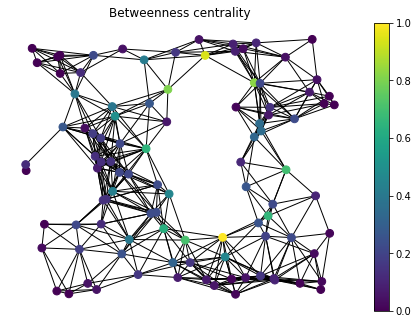

In [9]:
betweenness_centrality_labels = nx.betweenness_centrality(G)
plot_centrality(G,betweenness_centrality_labels,'Betweenness centrality')

### Katz centrality

Katz centrality can be considered a generalisation of degree centrality; degree centrality just looks at the neighbours at step 1 from a given vertex $v$. Katz centrality looks at all $l$-step paths from $v$, using the adjacency matrix.

Recall that the number of $l$-step walks from $v_i$ to $v_j$ is given by the $(i,j)^{th}$ element of $A^l$. We scale the importance of each walk by a factor of $\alpha^l$, for $0<\alpha<1$, which relies on the assumption that short walks are more important than long walks. An example of this is in a network modelling infectious disease, where you are more likely to pass on an infection to those who are closest to you.

Under this model, the weighted sum of the number of walks from $v_i$ to $v_j$ of various lengths $\geq 0$ is

$$I + \alpha A + \alpha^2 A^2 + \alpha^2 A^3 + \cdots = (I-\alpha A)^{-1}.$$

The **Katz centrality** is given by

$$C(v_i) = \sum_{j=1}^n[(I-\alpha A)^{-1}]_{ij}.$$

This is well-defined when $\alpha$ is smaller than the inverse of the largest eigenvalue of $A$, otherwise the sum does not converge.

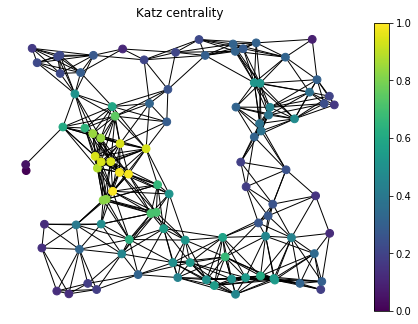

In [10]:
# find largest eigenvalue and compute centrality
A = nx.adjacency_matrix(G)
w, v = LA.eig(A.todense())
maxvalue = np.amax(w)
katz_centrality_labels = nx.katz_centrality(G,alpha=0.05,max_iter=10000)
plot_centrality(G, katz_centrality_labels, 'Katz centrality')

### Eigenvector centrality

This is a recursive centrality measure, based on the idea that vertices connected to high-scoring nodes should be scored higher than vertices connected to low-scoring nodes (with the same number of connections). 

$$C(v_i) = \frac{1}{\lambda}\sum_{j=1}^n a_{ij}x_j,$$

where $\lambda$ is a real number and $x_j=C(v_j)$. In fact, this can be rewritten as

$$A\mathbf{x} = \lambda\mathbf{x}$$

which makes it clearer to see that $\lambda$ is an eigenvalue of $A$ and $\mathbf{x}$ is an eigenvector. In general, of course, there is more than one eigenvalue; however, we have the additional requirement that all entries in $\mathbf{x}$ (the corresponding eigenvector) must be non-negative, so we take $\lambda$ to be the maximum eigenvalue (by the Perron–Frobenius theorem). This is well-defined when $G$ is undirected because then $A$ is a symmetric real-valued matrix, hence has all real eigenvalues.

There is still a choice of eigenvector to make, but we only care about *relative* scoring of vertices so we can normalise so that the sum of the $\mathbf{x}_i$ equals $1$ or $n$. Then, $C(v_i) = \mathbf{x}_j$.

In a social network, this is equivalent to saying that *someone with important friends is more important than someone with less important friends.*

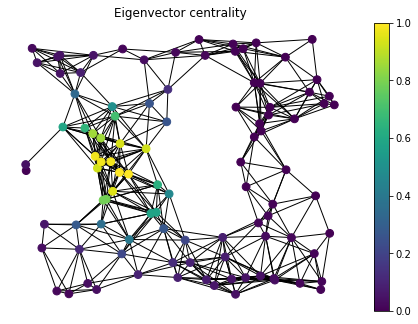

In [11]:
eigenvector_centrality_labels = nx.eigenvector_centrality(G)
plot_centrality(G, eigenvector_centrality_labels, 'Eigenvector centrality')

### Side-by-side comparison of all the measures so far

Keep in mind that all of the measures are normalised to have a range between $0$ and $1$ so it's all relative.

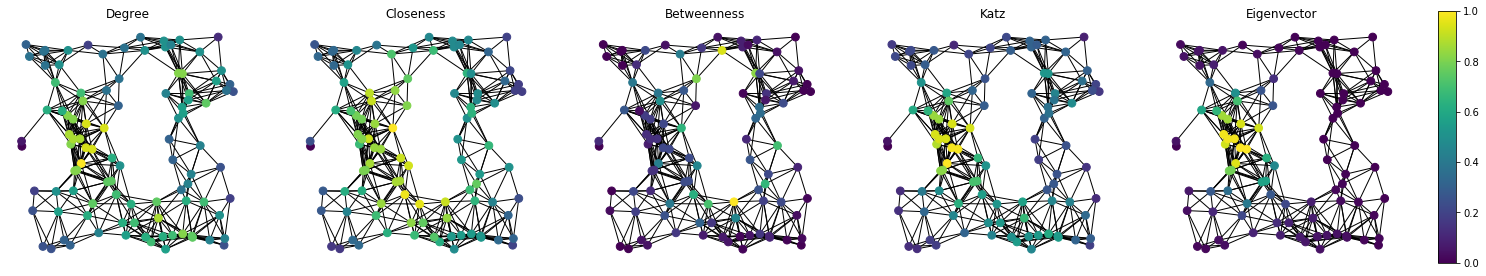

In [12]:
g, axes = plt.subplots(1,5,figsize=(25,5))

centralities = [degree_centrality_labels, 
                closeness_centrality_labels, 
                betweenness_centrality_labels, 
                katz_centrality_labels, 
                eigenvector_centrality_labels]

titles = ['Degree', 
          'Closeness', 
          'Betweenness', 
          'Katz', 
          'Eigenvector']

for k in range(5):
    ax = plt.subplot(1,5,k+1)
    ax.set_aspect('equal')
    plt.title(titles[k])   
    nx.draw(G, pos, node_size = 60, node_color = [centralities[k][i] for i in G.nodes()])

cbar_ax = g.add_axes([0.92, 0.17, 0.01, 0.7])
sm = plt.cm.ScalarMappable()
sm._A = []
plt.colorbar(sm,cax=cbar_ax)    

plt.show()

## Analysis of some real-world networks


### California road network

First we load in (part of) the [road network](http://snap.stanford.edu/data/roadNet-CA.html) of California. Nodes represent intersections and road endpoints and edges represent roads connecting these. We'll see that this graph isn't connected because we aren't loading in all 2,766,607 edges!

We take an induced subgraph on a few thousand nodes. Of course, this will introduce some error in accurately representing the road network so keep this in mind.

In [13]:
caliEdges = np.loadtxt('../data/roadNet-CA.txt')

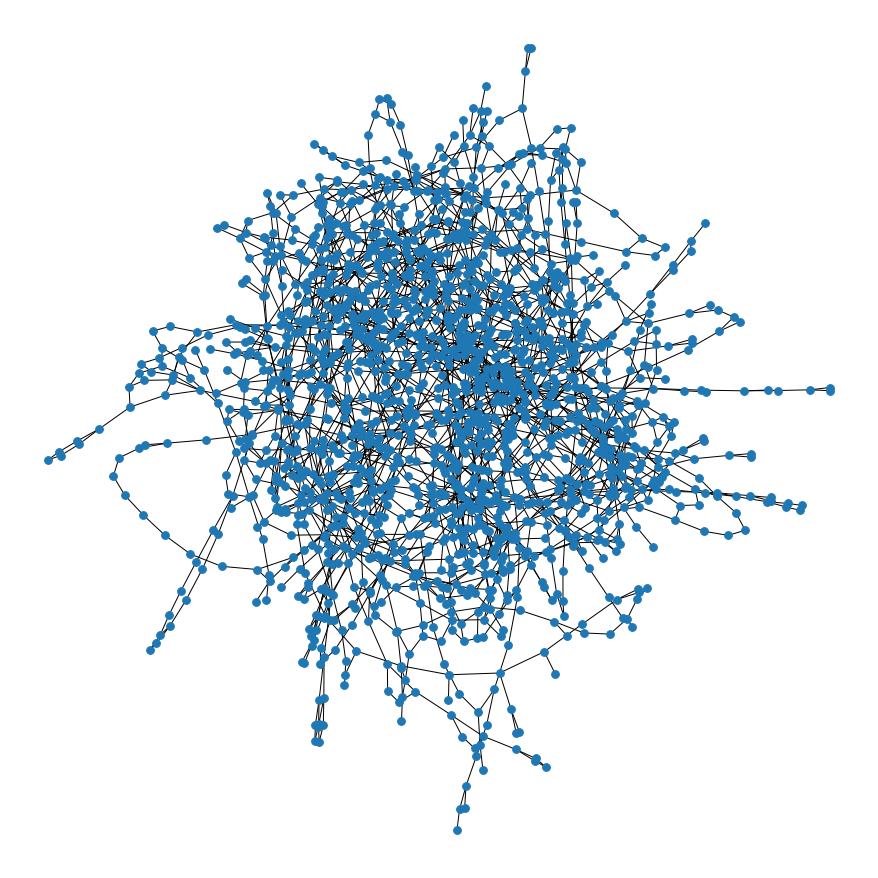

In [14]:
g = nx.Graph()
g.add_edges_from(caliEdges)
# take induced subgraph on first 1000 nodes
h = g.subgraph(range(10000))
comps = nx.connected_components(h)
big_conn_comp = list(comps)[0]
k = h.subgraph(big_conn_comp)
plt.figure(figsize=(12,12)) 
nx.draw_spring(k, node_size=60)

The first naive question we can try to answer is *what are the most important intersections in California?* If this was a geometric network (i.e. if the edges were weighted by their length or if the nodes came equipped with coordinates) we could consider the most important networks to be those having the most (weighted) shortest paths going through them (betweenness centrality). 

Similarly, if the edges were weighted by average time taken to traverse the road (perhaps even at a given time - rush hour/night time/middle of the day) then we could try to understand which intersections are most important to keep functioning perfectly (i.e. no broken traffic lights) at different times of the day. However, we don't have this information.

All we have is the 'topological' network - just the connections. Under the assumptions that
1. each edge corresponds to the same geometric distance, and
2. commuters take the shortest route from a to b,
we can use betweenness centrality to identify which intersections are most important for shortest routes through them. We also look at closeness centrality because this will pick up nodes that are close to lots of other nodes.

In [15]:
calibetweenness = nx.betweenness_centrality(k)
calicloseness = nx.closeness_centrality(k)

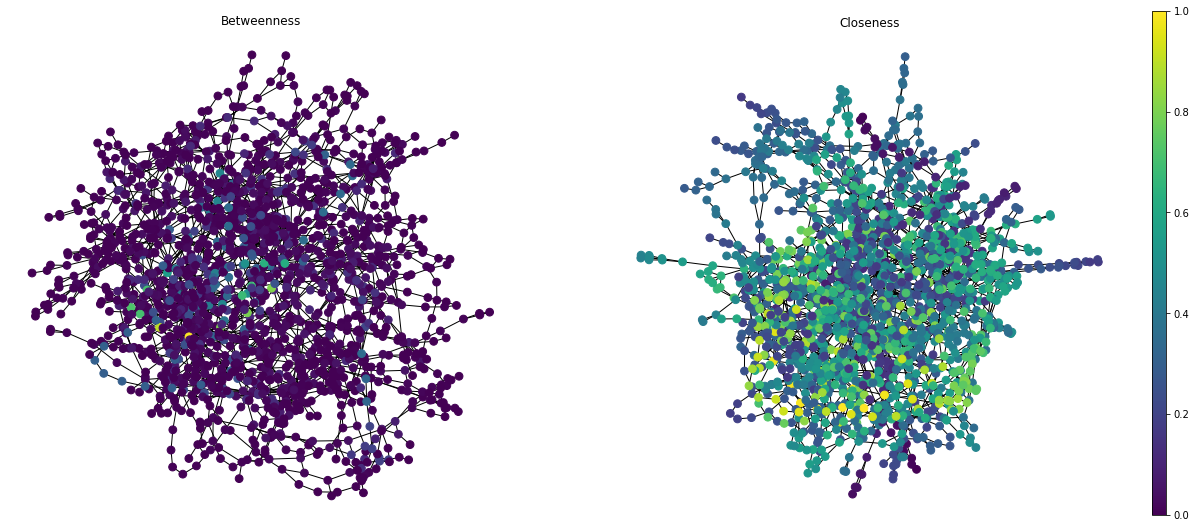

In [16]:
fig, axes = plt.subplots(1,2,figsize=(20,10))

centralities = [calibetweenness, 
                calicloseness]

titles = ['Betweenness', 
          'Closeness']

for j in range(2):
    ax = plt.subplot(1,2,j+1)
    ax.set_aspect('equal')
    plt.title(titles[j])
    
    nx.draw_spring(k, node_size = 60, node_color = [centralities[j][i] for i in k.nodes()])

cbar_ax = fig.add_axes([0.92, 0.17, 0.01, 0.7])
sm = plt.cm.ScalarMappable()
sm._A = []
plt.colorbar(sm,cax=cbar_ax)    

plt.show()

Unfortunately, as we don't have the geographical position of the nodes, we can't check which intersections the highest-valued nodes correspond to.

What we can say is that there are very few important intersections in this subgraph of the network.

### Primate social network

Cite [data](http://networkrepository.com/mammalia-primate-association-10.php).

This is a weighted network of primates, where there is an edge based of observed grooming between the two primates. The weight is based on the frequency of the grooming (over 3 months). Since this is undirected, we can't tell if a node with high degree is a giver or receiver of plenty of grooming, which makes it harder to answer the question: *who is the most important primate in the group?* assuming that primates higher up in the social hierarchy receive the most grooming.



In [17]:
primatepath = '../data/mammalia-primate-association-10/mammalia-primate-association-10.edges'
primate_edges = np.loadtxt(primatepath)

In [18]:
P = nx.Graph()
P.add_weighted_edges_from(primate_edges)

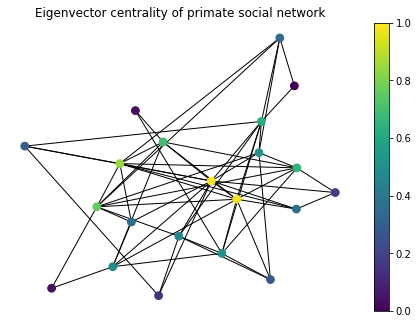

In [19]:
primate_eigenvector = nx.eigenvector_centrality(P)
nx.draw_spring(P, node_size = 60, node_color = [primate_eigenvector[i] for i in P.nodes()])
sm = plt.cm.ScalarMappable()
sm._A = []
plt.colorbar(sm)
plt.title('Eigenvector centrality of primate social network')
plt.show()

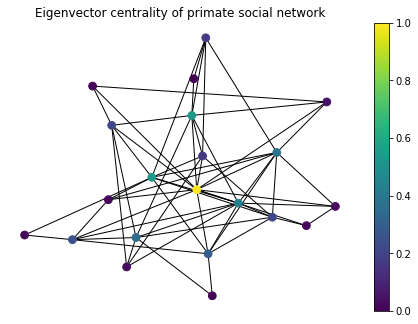

In [20]:
primate_betweenness = nx.betweenness_centrality(P)
nx.draw_spring(P, node_size = 60, node_color = [primate_betweenness[i] for i in P.nodes()])
sm = plt.cm.ScalarMappable()
sm._A = []
plt.colorbar(sm)
plt.title('Eigenvector centrality of primate social network')
plt.show()